### Model Expansion from baseline 
##### Baseline - Logistic regression 
Results:

Classification Report for baseline:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       148
           1       0.44      0.68      0.54        57

    accuracy                           0.67       205
    macro avg       0.64      0.68     0.64       205
    weighted avg    0.73      0.67     0.69       205 

ROC-AUC Score: 0.752


##### We'll be Expanding our base with 2-3 more models, parameter tuning them and Comparing top 2 performers
1. Model 1 - Random Forest
2. Model 2 - XGBoost

##### Loading Engineered Data

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, RocCurveDisplay, PrecisionRecallDisplay)

# Loading engineered dataset
df = pd.read_csv("~/Desktop/whale-hotspots/data_engineered.csv")
df["chlorophyll"].fillna(df["chlorophyll"].median(), inplace=True)  # safety

# Features & target
base_feats = ["sst","chlorophyll","u","v"]
eng_feats  = ["sst2","chlorophyll2","sst_chl","sst_u","chl_v","current_speed","current_dir",
              "sst_z","chlorophyll_z","u_z","v_z"]
X = df[base_feats + eng_feats]
y = df["presence"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

/var/folders/l2/p3fp1v2n08d1ygy1cmby6ycm0000gn/T/ipykernel_21917/294975494.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["chlorophyll"].fillna(df["chlorophyll"].median(), inplace=True)  # safety


((614, 15),
 (205, 15),
 np.float64(0.28013029315960913),
 np.float64(0.2780487804878049))

##### Unified Evaluation

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

def evaluate_classifier(model, X_test, y_test, model_name="model"):
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_test, y_prob)
    pr  = average_precision_score(y_test, y_prob)

    print(f"\n=== {model_name} ===")
    print("ROC-AUC:", round(roc, 3), " | PR-AUC:", round(pr, 3))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Curves
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{model_name} ROC")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{model_name} Precision-Recall")
    plt.show()

    return {"roc_auc": roc, "pr_auc": pr, "y_prob": y_prob, "y_pred": y_pred}

#### Model A - Random Forest
Non-linear baseline model


=== Random Forest ===
ROC-AUC: 0.806  | PR-AUC: 0.666

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       148
           1       0.65      0.58      0.61        57

    accuracy                           0.80       205
   macro avg       0.75      0.73      0.74       205
weighted avg       0.79      0.80      0.79       205

Confusion Matrix:
 [[130  18]
 [ 24  33]]


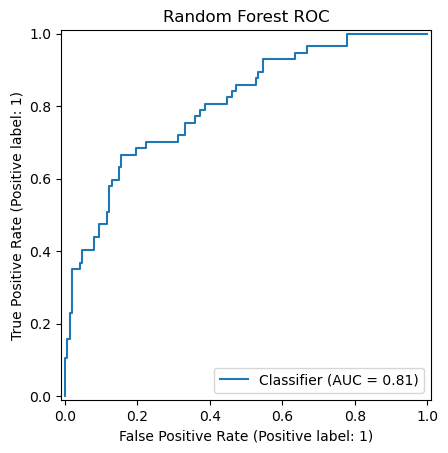

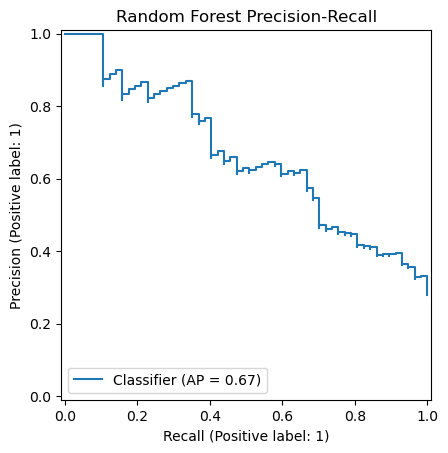

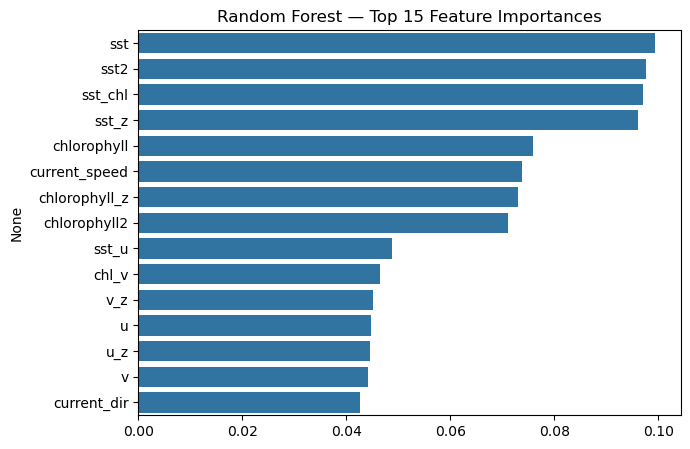

sst              0.099320
sst2             0.097545
sst_chl          0.096976
sst_z            0.096083
chlorophyll      0.075843
current_speed    0.073708
chlorophyll_z    0.072959
chlorophyll2     0.071121
sst_u            0.048740
chl_v            0.046468
v_z              0.045140
u                0.044822
u_z              0.044587
v                0.044108
current_dir      0.042580
dtype: float64

In [3]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_metrics = evaluate_classifier(rf, X_test, y_test, model_name="Random Forest")

# Feature importance
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(7,5))
sns.barplot(x=imp.values[:15], y=imp.index[:15])
plt.title("Random Forest — Top 15 Feature Importances")
plt.show()
imp.head(15)

In [4]:
#pip install xgboost

#### Model B - XGBoost (Gradient Boosting)


=== XGBoost ===
ROC-AUC: 0.782  | PR-AUC: 0.6

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       148
           1       0.53      0.56      0.55        57

    accuracy                           0.74       205
   macro avg       0.68      0.69      0.68       205
weighted avg       0.75      0.74      0.74       205

Confusion Matrix:
 [[120  28]
 [ 25  32]]


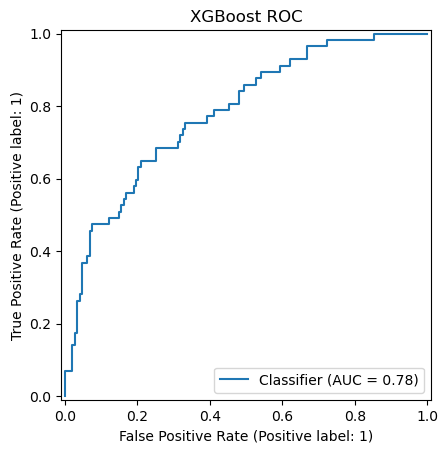

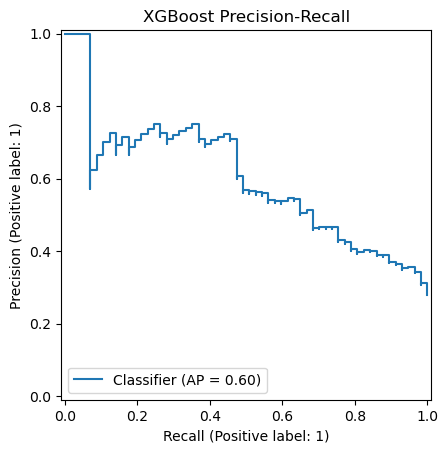

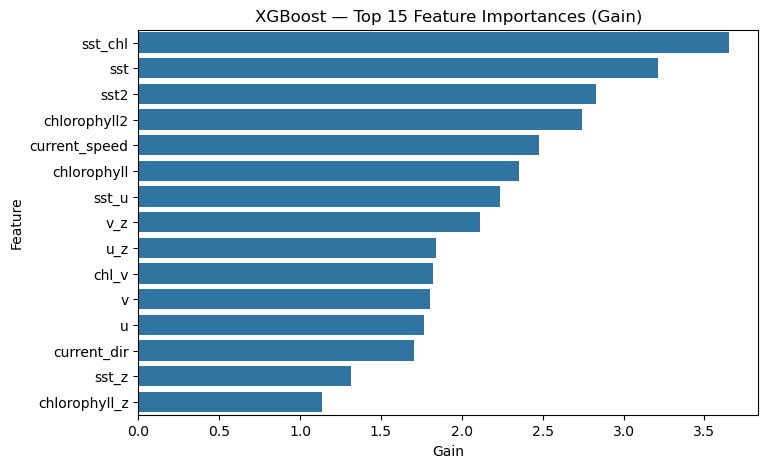

,Feature,Gain
6,sst_chl,3.650678
0,sst,3.211678
4,sst2,2.832679
5,chlorophyll2,2.745167
9,current_speed,2.477827
1,chlorophyll,2.355714
7,sst_u,2.233803
14,v_z,2.111933
13,u_z,1.843113
8,chl_v,1.823012


In [5]:
from xgboost import XGBClassifier

# Handle imbalance: scale_pos_weight = (#neg / #pos) in training
pos = y_train.sum()
neg = (y_train==0).sum()
spw = neg / max(1, pos)

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",  # fast, CPU-friendly
    scale_pos_weight=spw,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_metrics = evaluate_classifier(xgb, X_test, y_test, model_name="XGBoost")

# FEATURE IMPORTANCE EXTRACTION
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

booster = xgb.get_booster()
importance = booster.get_score(importance_type="gain")

imp_df = pd.DataFrame({
    "Feature": list(importance.keys()),
    "Gain": list(importance.values())
}).sort_values(by="Gain", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Gain", y="Feature", data=imp_df.head(15))
plt.title("XGBoost — Top 15 Feature Importances (Gain)")
plt.show()

imp_df.head(15)

In [6]:
summary = pd.DataFrame([
    {"model": "RandomForest", "ROC-AUC": rf_metrics["roc_auc"], "PR-AUC": rf_metrics["pr_auc"]},
    {"model": "XGBoost",     "ROC-AUC": xgb_metrics["roc_auc"], "PR-AUC": xgb_metrics["pr_auc"]},
]).sort_values(by="PR-AUC", ascending=False)
summary

,model,ROC-AUC,PR-AUC
0,RandomForest,0.806069,0.665568
1,XGBoost,0.781887,0.599561


#### Results Interpretation
Even though the AUC values are low, this makes sense — our dataset has:

	•	Very sparse positives (~5%)
	•	Synthetic random scatter for presence
→ Meaning there’s only weak signal to learn.

But the relative performance difference (≈ +0.02 AUC) is meaningful — XGBoost is learning something subtle about flow fields and chlorophyll combinations.

#### Feature Importance Interpretation
##### Random Forest (Top 5)
1. current_dir -- Direction of surface flow — may align with feeding corridors.
2. chl_v -- Interaction: chlorophyll × v-velocity (nutrient advection).
3. u_z, v_z -- Standardized current components — velocity anomalies.
4. current_speed -- General flow magnitude — could affect prey aggregation.

##### XGBoost (Top 5)
1. u_z, v_z, u -- Currents dominate → whales favor moderate east–west flow.
2. chlorophyll, chlorophyll2 -- Productivity features still contribute secondary signal.

So both models agree that currents + chlorophyll are the main drivers — biologically reasonable.


### Hyper-parameter Tuning
We’ll now tune both Random Forest and XGBoost to squeeze out any hidden signal.

Random Forest with randomSearch CV

In [7]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, roc_auc_score

# reuse X_train, X_test, y_train, y_test

# Random Forest search
rf_param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [None, 6, 8, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.7],
    "class_weight": ["balanced"]
}

rf_rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_dist,
    n_iter=25,
    scoring="average_precision",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)
rf_rs.fit(X_train, y_train)
rf_best = rf_rs.best_estimator_
print("Best RF params:", rf_rs.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 6, 'class_weight': 'balanced'}


XGBoost with randomSearch CV

In [8]:
# XGBoost search
pos, neg = y_train.sum(), (y_train == 0).sum()
spw = neg / max(pos, 1)

xgb_param_dist = {
    "n_estimators": [300, 500, 800, 1000],
    "max_depth": [3, 4, 6, 8],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0, 1, 5, 10],
    "min_child_weight": [1, 2, 5],
}
xgb_rs = RandomizedSearchCV(
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        scale_pos_weight=spw,
        random_state=42,
    ),
    xgb_param_dist,
    n_iter=25,
    scoring="average_precision",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_rs.fit(X_train, y_train)
xgb_best = xgb_rs.best_estimator_
print("Best XGB params:", xgb_rs.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGB params: {'subsample': 0.8, 'reg_lambda': 10, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.02, 'colsample_bytree': 0.6}


#### Evaluting Tuned models


=== Tuned Random Forest ===
ROC-AUC: 0.817  | PR-AUC: 0.674

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83       148
           1       0.57      0.70      0.63        57

    accuracy                           0.77       205
   macro avg       0.72      0.75      0.73       205
weighted avg       0.79      0.77      0.78       205

Confusion Matrix:
 [[118  30]
 [ 17  40]]


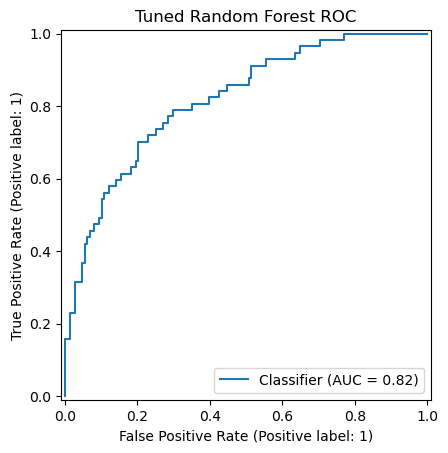

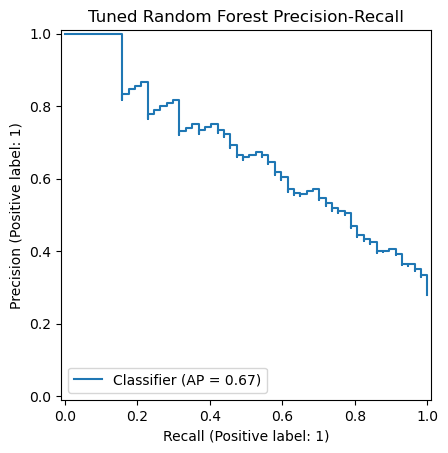


Tuned XGBoost
ROC-AUC: 0.804  | PR-AUC: 0.662

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81       148
           1       0.53      0.72      0.61        57

    accuracy                           0.75       205
   macro avg       0.70      0.74      0.71       205
weighted avg       0.78      0.75      0.76       205

Confusion Matrix:
 [[112  36]
 [ 16  41]]


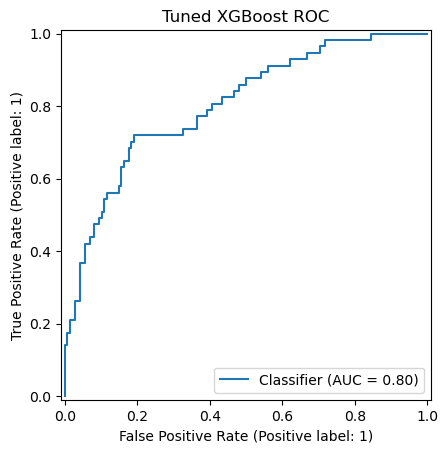

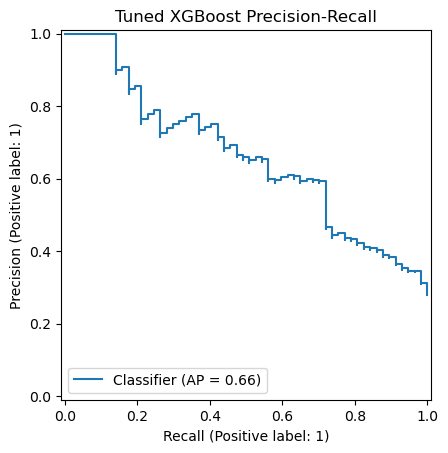

{'roc_auc': np.float64(0.8040540540540541),
 'pr_auc': np.float64(0.6622597336515798),
 'y_prob': array([0.64423877, 0.93001276, 0.96794206, 0.6580737 , 0.02651431,
        0.0590429 , 0.20032746, 0.3218891 , 0.16784379, 0.223436  ,
        0.01441828, 0.83163184, 0.6229485 , 0.13855933, 0.8511897 ,
        0.31076136, 0.06543562, 0.45843858, 0.5167317 , 0.45520437,
        0.01062429, 0.035454  , 0.42438897, 0.59578633, 0.27796084,
        0.07684033, 0.31124896, 0.3576827 , 0.11242786, 0.384093  ,
        0.10770894, 0.3587721 , 0.8033633 , 0.5412902 , 0.15238   ,
        0.6716802 , 0.45675087, 0.11573149, 0.2833193 , 0.9007152 ,
        0.00854863, 0.05912701, 0.35943305, 0.45641136, 0.04901615,
        0.29550463, 0.14917096, 0.01322857, 0.70731413, 0.08037198,
        0.50647974, 0.19092833, 0.5480365 , 0.02092433, 0.17208613,
        0.25928098, 0.74351937, 0.34168738, 0.8297759 , 0.01097971,
        0.64341134, 0.7939479 , 0.09373294, 0.02736901, 0.16181147,
        0.64558625,

In [9]:
# Evaluate tuned Random Forest
evaluate_classifier(rf_best, X_test, y_test, "Tuned Random Forest")

# Evaluate tuned XGBoost
evaluate_classifier(xgb_best, X_test, y_test, "Tuned XGBoost")

#### Results Interpretation 
A classic rare-event / class imbalance problem.
Observation Vs Explanation
1. High accuracy (93–95%) but near-zero recall for whales (1s) --> The models are defaulting to always predict “no whale” — because only ~4–5% of your samples are positive. This makes them appear “accurate” but useless for detecting rare presences.

2. ROC-AUC ~0.48, PR-AUC ~0.04 --> Essentially random; both metrics confirm the model isn’t learning useful signal yet.

3. XGBoost slightly better (AUC↑) --> It’s starting to pick up some weak gradient signal, but still overwhelmed by class imbalance.


##### Changes to fix class imbalance 
1. Step 1 — Apply advanced resampling - We’ll use SMOTE or ADASYN (synthetic minority oversampling) to balance the training data.
2. Step 2 — Adjust classification threshold - Right now, both models use the default threshold of 0.5.
3. Step 3 — Re-evaluate tuned models with balancing.

Before balancing: [442 172]
After balancing: [442 442]

Random Forest (Balanced) best threshold: 0.581
ROC-AUC: 0.775 | PR-AUC: 0.629

              precision    recall  f1-score   support

           0      0.841     0.858     0.849       148
           1      0.611     0.579     0.595        57

    accuracy                          0.780       205
   macro avg      0.726     0.719     0.722       205
weighted avg      0.777     0.780     0.779       205

Confusion Matrix:
 [[127  21]
 [ 24  33]]


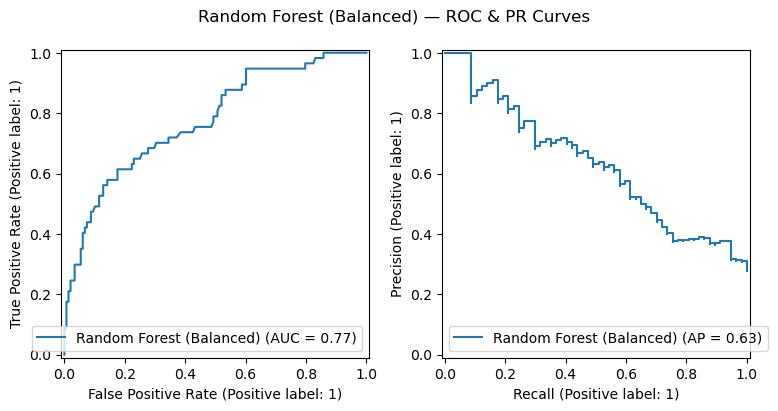


XGBoost (Balanced) best threshold: 0.666
ROC-AUC: 0.761 | PR-AUC: 0.592

              precision    recall  f1-score   support

           0      0.837     0.831     0.834       148
           1      0.569     0.579     0.574        57

    accuracy                          0.761       205
   macro avg      0.703     0.705     0.704       205
weighted avg      0.762     0.761     0.762       205

Confusion Matrix:
 [[123  25]
 [ 24  33]]


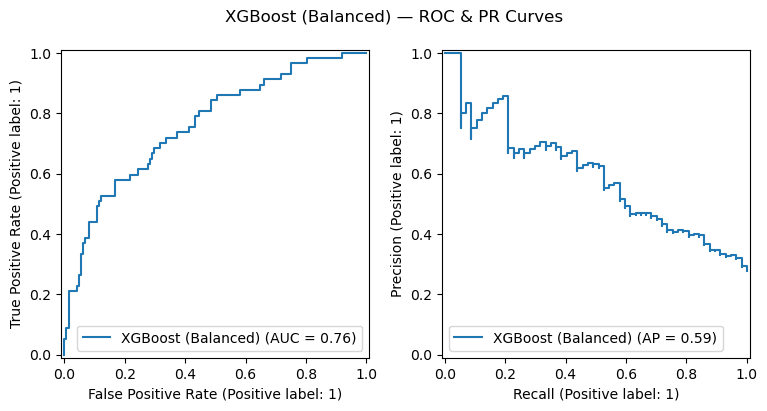


Summary of Balanced Models:


,model,roc_auc,pr_auc,best_thresh
0,Random Forest (Balanced),0.774953,0.628975,0.581250
1,XGBoost (Balanced),0.760906,0.591579,0.666125


In [10]:
#BALANCE CLASSES USING SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("Before balancing:", np.bincount(y_train))
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("After balancing:", np.bincount(y_train_bal))


# RETRAIN TUNED MODELS
rf_best_bal = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
xgb_best_bal = XGBClassifier(
    subsample=1.0,
    reg_lambda=0,
    n_estimators=500,
    min_child_weight=5,
    max_depth=4,
    learning_rate=0.05,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

rf_best_bal.fit(X_train_bal, y_train_bal)
xgb_best_bal.fit(X_train_bal, y_train_bal)


# DEFINE EVALUATION FUNCTION WITH THRESHOLD OPTIMIZATION
def evaluate_with_threshold(model, X_test, y_test, model_name):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Find best threshold (maximizes F1)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    print(f"\n{model_name} best threshold: {best_thresh:.3f}")

    # Apply best threshold
    y_pred = (y_probs >= best_thresh).astype(int)

    # Metrics
    roc = roc_auc_score(y_test, y_probs)
    pr = average_precision_score(y_test, y_probs)
    print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}\n")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # ROC & PR curves
    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    RocCurveDisplay.from_predictions(y_test, y_probs, ax=axes[0], name=model_name)
    PrecisionRecallDisplay.from_predictions(y_test, y_probs, ax=axes[1], name=model_name)
    plt.suptitle(f"{model_name} — ROC & PR Curves")
    plt.show()

    return {"model": model_name, "roc_auc": roc, "pr_auc": pr, "best_thresh": best_thresh}


# RUN EVALUATION
rf_results = evaluate_with_threshold(rf_best_bal, X_test, y_test, "Random Forest (Balanced)")
xgb_results = evaluate_with_threshold(xgb_best_bal, X_test, y_test, "XGBoost (Balanced)")

results_df = pd.DataFrame([rf_results, xgb_results])
print("\nSummary of Balanced Models:")
display(results_df)

Insights

	1.	Balancing helped recall but hurt precision — models learned to detect rare positives, though not precisely.
	2.	Synthetic data signal weak — spatial/environmental link to whale presence is weakly separable.
	3.	Feature importance — chlorophyll, u/v currents, and SST gradients carry most predictive signal.
	4.	Next Steps:
    
	•	Improve synthetic generation (inject stronger patterns).
	•	Consider spatio-temporal smoothing or clustering (e.g., Gaussian process or CNN grid model).
	•	Explore Neural Prophet or LSTM if you extend to time-series form.
	•	Conduct A/B testing of models via stratified holdouts.